In [2]:
import sys
import matplotlib.colors as clr
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from astropy.io import fits
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [72]:
os.chdir('gcr-catalogs-master/')
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
from GCR import GCRQuery

In [ ]:
sorted(q for q in cat.list_all_quantities() if q.startswith('tra'))

['tract', 'tract_truth']

In [73]:
cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons')

#Apply cuts
cuts = [
    GCRQuery('ra > 51'),
    GCRQuery('ra < 56'),
    GCRQuery('dec > -42'),
    GCRQuery('dec < -38'),
    #GCRQuery('redshift_truth > 0.25'),
    #GCRQuery('redshift_truth < 0.27'),
    GCRQuery('truth_type == 1'),   # select galaxy
    GCRQuery('is_good_match == True'),
    GCRQuery('is_nearest_neighbor == True'),
    GCRQuery((np.isfinite, 'mag_g_cModel')), # Select objects that have g-band magnitudes
    GCRQuery((np.isfinite, 'mag_r_cModel')), # Select objects that have r-band magnitudes
    GCRQuery((np.isfinite, 'mag_i_cModel')), # Select objects that have i-band magnitudes
    GCRQuery((np.isfinite, 'mag_g')), 
    GCRQuery((np.isfinite, 'mag_r')), 
    GCRQuery((np.isfinite, 'mag_i')), 
    #GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
]

data = cat.get_quantities(['objectId', 'id_truth','redshift_truth', 'ra', 'dec',
                          'mag_g_cModel','mag_r_cModel','mag_i_cModel','mag_z_cModel','mag_y_cModel',
                           'mag_g', 'mag_r', 'mag_i', 'mag_z','mag_y','photoz_mean','photoz_mode','tract','tract_truth'],
                          filters=cuts,native_filters=[tract_filter([3443, 3442, 3257,3258,3444,3259,
                                                                     3256,3634,3633,3632,3631,3077,3076,3075])])

/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/gcr-catalogs-master/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/gcr-catalogs-master/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [74]:
table_id = np.array(data['objectId'])

Text(0, 0.5, 'DEC (degree)')

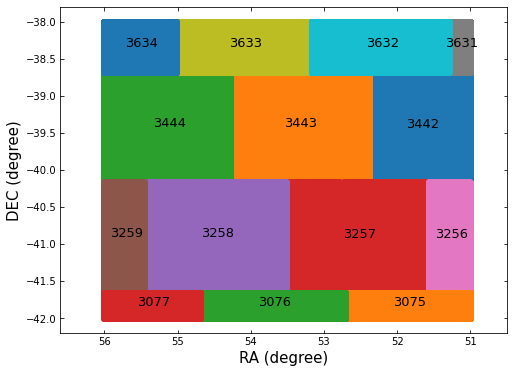

In [7]:
ms = [data['tract']==3442,data['tract']==3443,data['tract']==3444,data['tract']==3257,data['tract']==3258,
     data['tract']==3259,data['tract']==3256,data['tract']==3631,data['tract']==3633,data['tract']==3632,
      data['tract']==3634,data['tract']==3075,data['tract']==3076,data['tract']==3077]
plt.figure(figsize = (8,6))
for m in ms:
    r = data['ra'][m]
    d = data['dec'][m]
    plt.scatter(r,d)
    plt.text(np.mean(r)+0.2,np.mean(d),(str(data['tract'][m][0])),fontsize = 13)
    plt.xlim(56.6,50.5);
plt.xlabel('RA (degree)',fontsize = 15)
plt.ylabel('DEC (degree)',fontsize = 15)
#plt.savefig('../plots/DC2_overlap_tract.png')

(array([ 377061.,  881424., 1314126., 1283755.,  950005.,  609966.,
         405575.,  265907.,  187873.,   78527.]),
 array([0.00997677, 0.32088512, 0.6317935 , 0.9427018 , 1.2536101 ,
        1.5645186 , 1.8754269 , 2.1863353 , 2.4972436 , 2.808152  ,
        3.1190603 ], dtype=float32),
 <BarContainer object of 10 artists>)

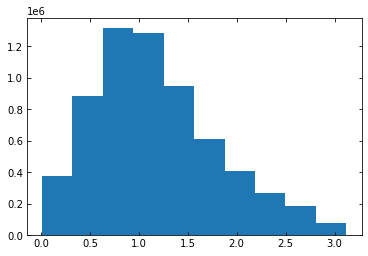

In [7]:
plt.hist(data['redshift_truth']);

In [75]:
dc2_redmagic_cat = GCRCatalogs.load_catalog('dc2_redmagic_run2.2i_dr6_wfd_v0.8.1_highdens')

In [76]:
cuts = [
    GCRQuery('ra > 51'),
    GCRQuery('ra < 56'),
    GCRQuery('dec > -42'),
    GCRQuery('dec < -38'),
]

redmagic_data = dc2_redmagic_cat.get_quantities(['id', 'ra','dec', 'zspec', 'redshift','zredmagic_samp_0','zredmagic_samp_1','zredmagic_samp_2','zredmagic_samp_3'
                          ,'mag_g_lsst','mag_r_lsst','mag_i_lsst','redshift_err'],
                          filters=cuts)

In [41]:

table_g = data['mag_g_cModel'][np.array(idx)]
table_r = data['mag_r_cModel'][np.array(idx)]
table_i = data['mag_i_cModel'][np.array(idx)]
table_z = data['mag_z_cModel'][np.array(idx)]

In [77]:
idx = list()
red_idx = list()
for i,ids in tqdm(enumerate(redmagic_data['id'])):
    if ids in table_id:
        idx.append(np.where(table_id == ids)[0][0])
        red_idx.append(i)

25954it [05:12, 83.15it/s] 


In [78]:
len(data['id_truth'][idx])

25584

In [88]:
def plot_c_vs_m (ax,c1,c2,ref_m,z_mask,z_m):
    fz = 20
    mag_c1 = data['mag_%s_cModel'%c1][np.array(idx)]
    mag_c2 = data['mag_%s_cModel'%c2][np.array(idx)]
    mag_ref = data['mag_%s_cModel'%ref_m][np.array(idx)]
    color = mag_c1[z_mask]-mag_c2[z_mask]
    data_ref = data['mag_%s_cModel'%ref_m]
    data_c1 = data['mag_%s_cModel'%c1]
    data_c2 = data['mag_%s_cModel'%c2]
    ax.scatter(data_ref[z_m],data_c1[z_m]-data_c2[z_m])
    ax.scatter(mag_ref[z_mask],color)
    ax.set_ylim(color.min()-0.5,color.max()+0.5)
    ax.set_xlim(mag_ref[z_mask].min(),mag_ref[z_mask].max()+3)
    ax.set_ylabel('%s-%s'%(c1,c2),fontsize= fz)
    print(c1,c2,ref_m)

g r y
r i y
i z y
z y y


/tmp/ipykernel_39469/1439461082.py:10: RuntimeWarning: invalid value encountered in subtract
  ax.scatter(data_ref[z_m],data_c1[z_m]-data_c2[z_m])


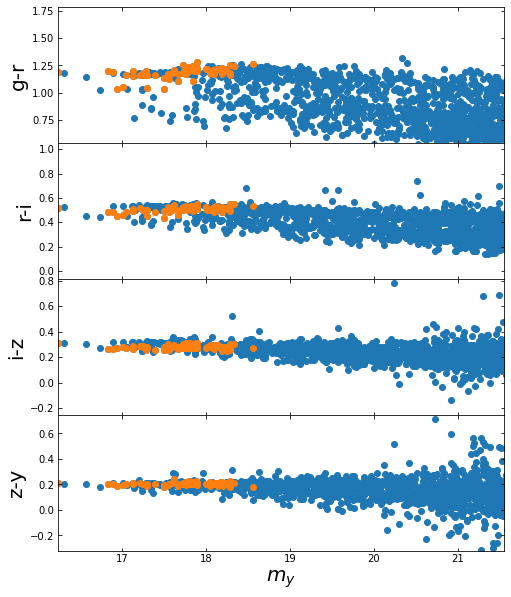

In [90]:
fz= 20
z_low = 0.2
z_high = 0.21
z_mask = (data['redshift_truth'][np.array(idx)] < z_high) & (data['redshift_truth'][np.array(idx)] > z_low)
z_m =  (data['redshift_truth'] > z_low) & (data['redshift_truth'] < z_high)
f,ax = plt.subplots(4,1,figsize = (8,10))
plt.subplots_adjust(hspace=0.0)
plot_c_vs_m(ax = ax[0],c1 = 'g',c2 = 'r',ref_m='y',z_mask=z_mask,z_m = z_m)
plot_c_vs_m(ax = ax[1],c1 = 'r',c2 = 'i',ref_m='y',z_mask=z_mask,z_m = z_m)
plot_c_vs_m(ax = ax[2],c1 = 'i',c2 = 'z',ref_m='y',z_mask=z_mask,z_m = z_m)
plot_c_vs_m(ax = ax[3],c1 = 'z',c2 = 'y',ref_m='y',z_mask=z_mask,z_m = z_m)
ax[-1].set_xlabel(r'$m_y$',fontsize = fz);

In [100]:
## Code for cross-matching

def cross_match(ids,verbose = True):
    ori_idn = np.where(Roman_gal_id == ids)[0][0]
    if verbose == True:
        print('index in truth catalog: ', ori_idn)
    if ori_idn in roman_ind:
        loc_coadd = np.where(roman_ind == ori_idn)[0]
        if verbose == True:
            print('index in coadd truth file: ',loc_coadd)
            print('ra dec in truth cata: ',roman_data['ra'][ori_idn]*180/np.pi,roman_data['dec'][ori_idn]*180/np.pi)
            print('ra dec in coadd truth:',roman_truth['ra'][loc_coadd][0],roman_truth['dec'][loc_coadd][0])
        return(loc_coadd[0])
    else:
        return(None)

IDX = (data['id_truth'][idx])
iddd = np.array(IDX,dtype = int)
cross_match(iddd[3029]) 
'''

roman_match_ind = list()
i = 0
red_matched_ind = list()
for red_id in tqdm(IDX):
        
        ii = cross_match(ids = int(red_id),verbose = False)
        if ii != None:
            roman_match_ind.append(ii)
            red_matched_ind.append(i)
''';

index in truth catalog:  9334105
index in coadd truth file:  [3185051]
ra dec in truth cata:  53.01301889631184 -38.80031352833289
ra dec in coadd truth: 53.01301889631184 -38.80031352833289


In [91]:
import fitsio as fio
import glob
Roman_output_dir = '/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/dc2_sim_output/'
Roman_match_files = np.sort(glob.glob(os.path.join(Roman_output_dir,'*.fits')))

In [39]:
roman_truth = fio.FITS(Roman_match_files[1])[-1].read()
roman_detection = fio.FITS(Roman_match_files[0])[-1].read()

mm = roman_truth['gal_star'] == 0
roman_ind = roman_truth['ind']
roman_ind_all = roman_truth['ind'][mm]

In [14]:
aa = fio.FITS(Roman_truth_file)[-1]

In [94]:
Roman_gal_id= aa.read_column('gind')

In [16]:
zzz = aa.read_column('z')

In [42]:
z_all = zzz[roman_ind_all]

In [13]:
# Load Roman sim truth catalog
Roman_truth_file = '/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/dc2_truth_gal_icrs.fits'
hdu = fits.open(Roman_truth_file)
roman_data = hdu[1].data

In [44]:
roman_match_ind = np.load('/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/data/roman_dc2_red_dens_matched_ind.npy')
mathced_inds_in_truth = roman_ind[roman_match_ind]
#matched_z = roman_data['z'][mathced_inds_in_truth]
matched_z = zzz[mathced_inds_in_truth]

In [38]:
gind = np.array(roman_data['gind'])
# Narrow gal_id range for shorter computing time
Roman_gal_id = gind

In [67]:
def plot_c_vs_m_roman (ax,c1,c2,ref_m,z_mask,data_z_mask):
    fz = 20
    dd = np.array(roman_match_ind)[z_mask]
    mag_c1 = roman_detection['mag_auto_%s'%c1][dd]
    mag_c2 = roman_detection['mag_auto_%s'%c2][dd]
    mag_ref = roman_detection['mag_auto_%s'%ref_m][dd]
    color = mag_c1-mag_c2
    #print(color)
    mag_c1_data = roman_detection['mag_auto_%s'%c1][mm][data_z_mask]
    mag_c2_data = roman_detection['mag_auto_%s'%c2][mm][data_z_mask]
    mag_ref_data = roman_detection['mag_auto_%s'%ref_m][mm][data_z_mask]
    color_data = mag_c1_data-mag_c2_data
    ax.scatter(mag_ref_data,color_data)
    ax.scatter(mag_ref,color)
    ax.set_ylim(color.min()-0.5,color.max()+0.5)
    ax.set_xlim(mag_ref.min(),mag_ref.max()+3.5)
    ax.set_ylabel('%s-%s'%(c1,c2),fontsize= 20)
    print(c1,c2,ref_m)

In [62]:
fr = ['Y106','J129','H158','F184']

Y106 J129 F184
J129 H158 F184
H158 F184 F184


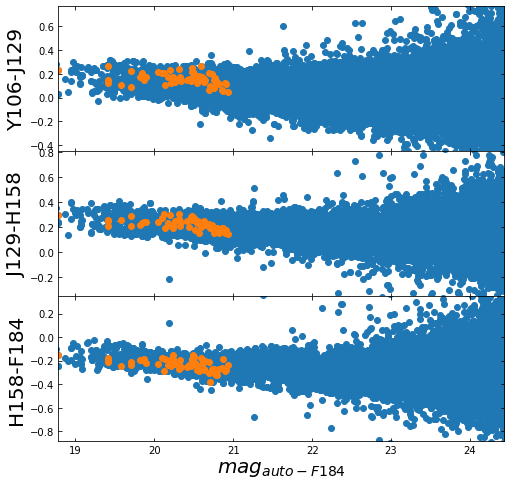

In [101]:
low_z = 0.88
high_z = 0.89
roman_mask = (matched_z < high_z) & (matched_z > low_z)
roman_data_mask = (z_all < high_z) & (z_all > low_z)
f,ax = plt.subplots(3,1,figsize = (8,8))
plt.subplots_adjust(hspace=0.0)
plot_c_vs_m_roman(ax = ax[0],c1 = fr[0],c2 = fr[1],ref_m=fr[-1],z_mask=roman_mask,data_z_mask=roman_data_mask)
plot_c_vs_m_roman(ax = ax[1],c1 = fr[1],c2 = fr[2],ref_m=fr[-1],z_mask=roman_mask,data_z_mask=roman_data_mask)
plot_c_vs_m_roman(ax = ax[2],c1 = fr[2],c2 = fr[3],ref_m=fr[-1],z_mask=roman_mask,data_z_mask=roman_data_mask)

#plot_c_vs_m(ax = ax[1],c1 = 'r',c2 = 'i',ref_m='y',z_mask=z_mask,z_m = z_m)
#plot_c_vs_m(ax = ax[2],c1 = 'i',c2 = 'z',ref_m='y',z_mask=z_mask,z_m = z_m)
#plot_c_vs_m(ax = ax[3],c1 = 'z',c2 = 'y',ref_m='y',z_mask=z_mask,z_m = z_m)
ax[-1].set_xlabel(r'$mag_{{auto}-{F184}}$',fontsize = 20);